## 01 Asset Data Collection

Before testing any portfolio strategy we need data first of all. I want to focus on two ways to collect data:
1. directly from the web by using the `yfinance` library, that takes data from Yahoo Finance;
2. from `.csv` files downloaded and strored from *Investing.com* - for example - or any other source.

Having this second approach as backup data source might be helpful when the first doesn't work for any reason realated to either Yahoo Finance or `yfinance` or both.

In this notebook I want to define one or two functions to collect asset daily price data and put them in a file called `Utils.py` from which I can call directly these functions and see the results in few lines of code.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
plt.style.use('ggplot')

### 1. Taking Data by using `yfinance`

In [3]:
yf.download(tickers='CSSPX.MI', progress=False, auto_adjust=False).head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,CSSPX.MI,CSSPX.MI,CSSPX.MI,CSSPX.MI,CSSPX.MI,CSSPX.MI
Date,,,,,,
2010-05-19,72.849998,72.849998,72.849998,72.849998,72.849998,0
2010-05-20,72.849998,72.849998,72.849998,72.849998,72.849998,0
2010-05-21,72.849998,72.849998,72.849998,72.849998,72.849998,0
2010-05-24,72.849998,72.849998,72.849998,72.849998,72.849998,0
2010-05-25,72.849998,72.849998,72.849998,72.849998,0.000000,0


In [4]:
yf.download(tickers='CSSPX.MI', progress=False).head()

YF.download() has changed argument auto_adjust default to True


Price,Close,High,Low,Open,Volume
Ticker,CSSPX.MI,CSSPX.MI,CSSPX.MI,CSSPX.MI,CSSPX.MI
Date,,,,,
2010-05-19,72.849998,72.849998,72.849998,72.849998,0
2010-05-20,72.849998,72.849998,72.849998,72.849998,0
2010-05-21,72.849998,72.849998,72.849998,72.849998,0
2010-05-24,72.849998,72.849998,72.849998,72.849998,0
2010-05-25,72.849998,72.849998,72.849998,0.000000,0


Notice that the argument `auto_adjust=True` by default. Therefore if we want the Adjusted Closing Price of our ticker, we need to set the argument `auto_adjust` to `False`.

When testing strategies, we are usually interested in the `Close` or `Adj Close` price of the ticker. So we can use the `.loc` method to subset the MultIndex Columns in the DataFrame of our ticker series and store the ticker's historical prices into a `pd.Series`.

In [5]:
yf.download(tickers='CSSPX.MI', progress=False, auto_adjust=False).loc[:,('Adj Close','CSSPX.MI')].head()

Date
2010-05-19    72.849998
2010-05-20    72.849998
2010-05-21    72.849998
2010-05-24    72.849998
2010-05-25    72.849998
Name: (Adj Close, CSSPX.MI), dtype: float64

Now I want to write a function that takes the historical `Prices` of a ticker from Yahoo Finance and stores them into a `pd.Series`.

In [6]:
def prices(ticker, price='Adj Close'):
    """Retrieves daily price data for a given ticker symbol from the Milan Stock Exchange (Borsa Italiana).

    Args:
        ticker (str): The ticker symbol of the stock. 
        price (str, optional): The type of price data to retrieve. Can be either 'Close' or 'Adj Close' (default).

    Returns:
        pandas.Series: daily price data for the specified ticker, indexed by date.
    """
    if price != 'Adj Close':
        # append '.MI' to the ticker to fetch data from the Milan Stock Exchange.
        data = yf.download(tickers=ticker+'.MI', 
                             progress=False).loc[:,('Close',ticker+'.MI')]
    else:
        # append '.MI' to the ticker to fetch data from the Milan Stock Exchange.
        data = yf.download(tickers=ticker+'.MI', 
                             progress=False, auto_adjust=False).loc[:,('Adj Close',ticker+'.MI')]
    
    # giving ticker's name to data
    data.name = ticker
    
    return data 

<Axes: xlabel='Date'>

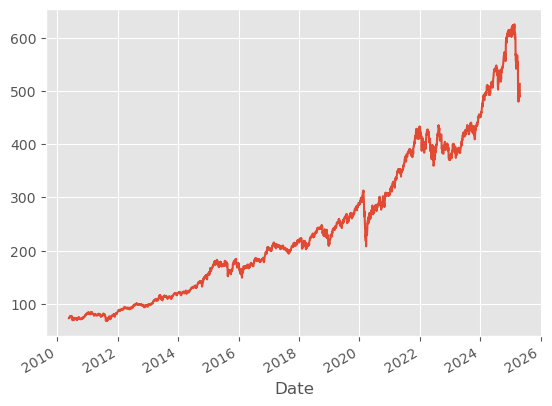

In [7]:
prices(ticker='CSSPX', price='Close').plot()

### 2. Taking Data by using `.csv` files from *Investing.com*

I read the data from a ticker `.csv` file stored in the `historical_series` folder.

In [8]:
pd.read_csv('historical_series/PHAU.csv').head()

,Date,Price,Open,High,Low,Vol.,Change %
0,04/04/2025,256.66,261.18,264.61,256.66,14.68K,-2.13%
1,04/03/2025,262.24,265.31,266.13,256.37,32.30K,-2.32%
2,04/02/2025,268.46,269.02,270.56,267.90,19.79K,-0.56%
3,04/01/2025,269.96,270.38,271.33,269.50,19.03K,0.27%
4,03/31/2025,269.24,268.65,269.97,267.64,18.30K,1.37%


In [9]:
prices = pd.read_csv('historical_series/PHAU.csv')
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4518 entries, 0 to 4517
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      4518 non-null   object 
 1   Price     4518 non-null   float64
 2   Open      4518 non-null   float64
 3   High      4518 non-null   float64
 4   Low       4518 non-null   float64
 5   Vol.      4482 non-null   object 
 6   Change %  4518 non-null   object 
dtypes: float64(4), object(3)
memory usage: 247.2+ KB


Also this case, when testing strategies, we are usually interested in the `Close` or `Adj Close` price of the ticker. So we can use the `.loc` method to subset the `Price` in the DataFrame of our ticker series and store the ticker's historical prices into a `pd.Series`.
Because the column `Date` is an object `Dtype` we need to convert it in a `dtype = datetime64[ns]` object.

In [10]:
# Convert 'Date' column to datetime objects if it's not already
prices['Date'] = pd.to_datetime(prices['Date'])
# sorting prices by 'Date' and resetting index
prices = prices.sort_values(by='Date').set_index('Date')
prices = prices.loc[:,'Price']

prices.head()

Date
2007-06-20    49.00
2007-06-21    49.00
2007-06-22    49.00
2007-06-25    49.00
2007-06-26    48.23
Name: Price, dtype: float64

Now I want to add the additional argument `source` to the function `prices`. If `source = 'csv'`, the function takes the historical `Prices` of a ticker from the files stored in the `historical_series` folder. Otherwise from Yahoo Finance. In both cases, the function `prices` returns the historical `Prices` as a `pd.Series`.

In [11]:
def prices(ticker, source='yf', price='Adj Close'):
    """Retrieves daily price data for a given ticker symbol from the Milan Stock Exchange (Borsa Italiana).

    Args:
        ticker (str): The ticker symbol of the stock.
        source (str, optional): The source of price data to retrive. Can be either 'csv' or 'yf'.
            - 'csv': Reads data from a CSV file named '{ticker}.csv' in the 'historical_series/' subdirectory.
            - 'yf' (default): Fetches data from Yahoo Finance. '.MI' is automatically appended.
        price (str, optional): The type of price data to retrieve. Can be either 'Close' or 'Adj Close'.
            - 'Close': Takes the Closing price of the ticker.
            - 'Adj Close' (default): Takes the Adjusted Closing price of the ticker.

    Returns:
        pandas.Series: daily price data for the specified ticker, indexed by date.
    """
    if source == 'csv':
        data = pd.read_csv('historical_series/' + ticker + '.csv')
        # Convert 'Date' column to datetime objects if it's not already
        data['Date'] = pd.to_datetime(data['Date'])
        # sorting data by 'Date' and resetting index
        data = data.sort_values(by='Date').set_index('Date')
        data = data.loc[:,'Price']
            
    else:
        if price != 'Adj Close':
            # append '.MI' to the ticker to fetch data from the Milan Stock Exchange.
            data = yf.download(tickers=ticker+'.MI', 
                                progress=False).loc[:,('Close',ticker+'.MI')]
        else:
            # append '.MI' to the ticker to fetch data from the Milan Stock Exchange.
            data = yf.download(tickers=ticker+'.MI', 
                                progress=False, auto_adjust=False).loc[:,('Adj Close',ticker+'.MI')]
    
    # giving ticker's name to data
    data.name = ticker
    
    return data

<Axes: xlabel='Date'>

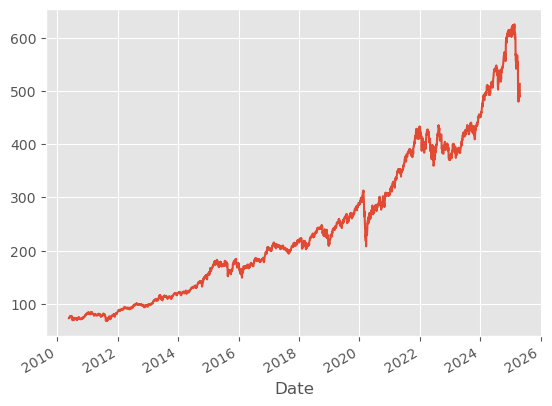

In [12]:
prices(ticker='CSSPX').plot()

<Axes: xlabel='Date'>

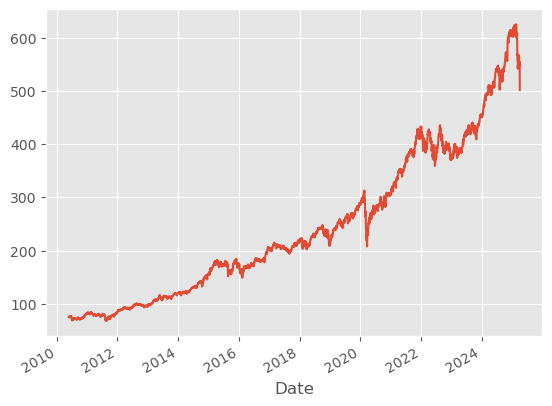

In [13]:
prices(ticker='CSSPX', source='csv').plot()

### Summary

This chapter covers two methods for getting historical asset prices: directly from *Yahoo Finance* or from `.csv` files I downloaded from *Investing.com* and saved in a folder called `historical_series`. I created a `prices()` function that retrieves daily price data for a given asset symbol from either source (`'csv'` or `'yf'`).